# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid

## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Utils functions

In [3]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

## Load Dataset

In [4]:
gm_df = gm.load_game_matchup_dataset()

## Experiments

### Setup

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [6]:
exp_prefix = ""
exp_group_name = ""
results_total = []
exp.exp_results = []
exp_X_columns = model_config.X_candidate_features
exp_y_columns = model_config.y_candidate_features

### Dataset

El paramatero max_split de la clase TimeSeriesSplit permite dividir el dataset por cantidad de filas, por lo que vamos a escoger solo las temporadas que tienen la misma cantidad de partidos.


In [7]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [8]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [9]:
# tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=1230)
# X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
# print(len(X))
# for train_index, test_index in tscv.split(X=X):
#     print("dtype: ", type(train_index))
#     print("TRAIN:", train_index, "TEST:", test_index)

### Algorithms 

In [10]:
models = exp.get_models()

### Create Season Time Series Split

In [11]:
sscv = utils.SeasonSeriesSplit(df)

### Experiment using 1 season

In [12]:
experiment_name = f"{exp_prefix}1_season"

In [13]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 1_season
KNN
balanced_accuracy: 0.6371383240895643 - 0.013096400586011398
precision: 0.6895053736535 - 0.015561404209993643
recall: 0.6528455284552845 - 0.012841926015391301
f1: 0.6499679987217758 - 0.013561244118973427
roc_auc: 0.6371383240895643 - 0.013096400586011398
SVM
balanced_accuracy: 0.6925515127344388 - 0.01854879007225907
precision: 0.736749932405744 - 0.023520410300945337
recall: 0.7046747967479674 - 0.015841928118008025
f1: 0.7027663882773783 - 0.017156204807780535
roc_auc: 0.6925515127344389 - 0.01854879007225914
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5815040650406504 - 0.005185914968363031
recall: 0.5815040650406504 - 0.005185914968363031
f1: 0.4276406676594567 - 0.006226193855456991
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5518934178096364 - 0.04650580897131376
precision: 0.6709662007216244 - 0.06886791328311831
recall: 0.5457317073170732 - 0.0850018857224738
f1: 0.4650501599822187 - 0.12003897920437745
roc_auc: 0.5518934178096364 - 0.046505

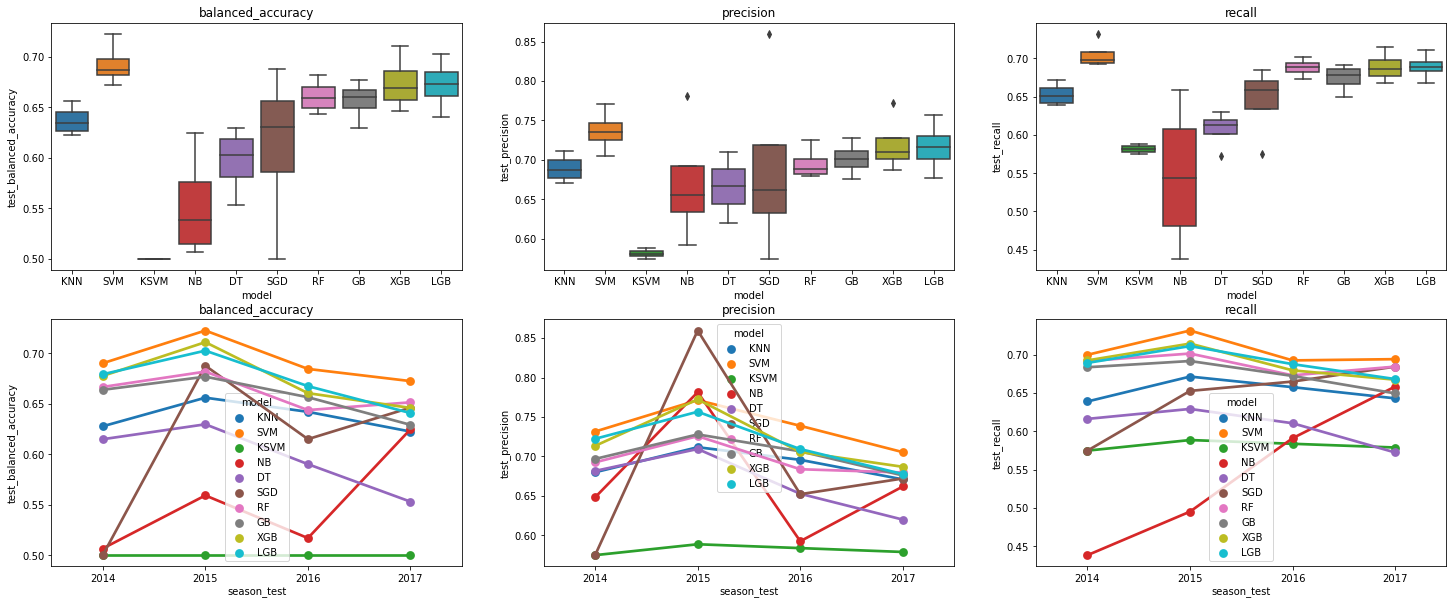

In [14]:
#### Visualize experiments results
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%.

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.6925515127344388 - 0.01854879007225907
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.6738674403149788 - 0.024290520850604853
    - ***LGB***: Obtuvo el tercer promedio mas alto. balanced_accuracy: 0.6726459601145429 - 0.022280716932570364
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment using StandardScaler

In [15]:
experiment_name = f"{exp_prefix}scaled_data"

In [16]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y, True)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment scaled_data
KNN
balanced_accuracy: 0.6792983447415086 - 0.0197533788391945
precision: 0.7294281040652774 - 0.024970646542622085
recall: 0.6896341463414634 - 0.015515201000717658
f1: 0.688655605672625 - 0.016971161165889564
roc_auc: 0.6792983447415086 - 0.019753378839194462
SVM
balanced_accuracy: 0.6531600890193751 - 0.08619576582931333
precision: 0.7091359277591953 - 0.07440376889340568
recall: 0.6788617886178863 - 0.055988464672198854
f1: 0.6414840832522717 - 0.12031746008951517
roc_auc: 0.653160089019375 - 0.08619576582931336
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5815040650406504 - 0.005185914968363031
recall: 0.5815040650406504 - 0.005185914968363031
f1: 0.4276406676594567 - 0.006226193855456991
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5387019687254156 - 0.03544305590411643
precision: 0.7474710011049982 - 0.11259033696735987
recall: 0.5054878048780488 - 0.07520297736710993
f1: 0.4032792226939139 - 0.1159382551442801
roc_auc: 0.5387019687254156 - 0.03544

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGD
balanced_accuracy: 0.6138210964389997 - 0.11165273337170073
precision: 0.5411550524753279 - 0.32414693346076257
recall: 0.6111788617886178 - 0.1264095292787352
f1: 0.5318196335571124 - 0.20406078397083532
roc_auc: 0.6138210964389996 - 0.11165273337170073
RF
balanced_accuracy: 0.6301169245840191 - 0.07394825674773713
precision: 0.6780059703216281 - 0.05904787496646977
recall: 0.6652439024390244 - 0.04922015612450471
f1: 0.6231835264783808 - 0.11037324713123993
roc_auc: 0.6301169245840191 - 0.07394825674773717
GB
balanced_accuracy: 0.6549287415938634 - 0.03889005370087856
precision: 0.7346409623567846 - 0.03082413427802787
recall: 0.6548780487804878 - 0.06307366117554022
f1: 0.644495129605204 - 0.07552420071072997
roc_auc: 0.6549287415938632 - 0.03889005370087854
XGB
balanced_accuracy: 0.667716032533138 - 0.027865425583437218
precision: 0.712634645946471 - 0.033164898510181104
recall: 0.6847560975609757 - 0.019549211162663938
f1: 0.6798504522240089 - 0.0246931953492866
roc_auc: 0.667

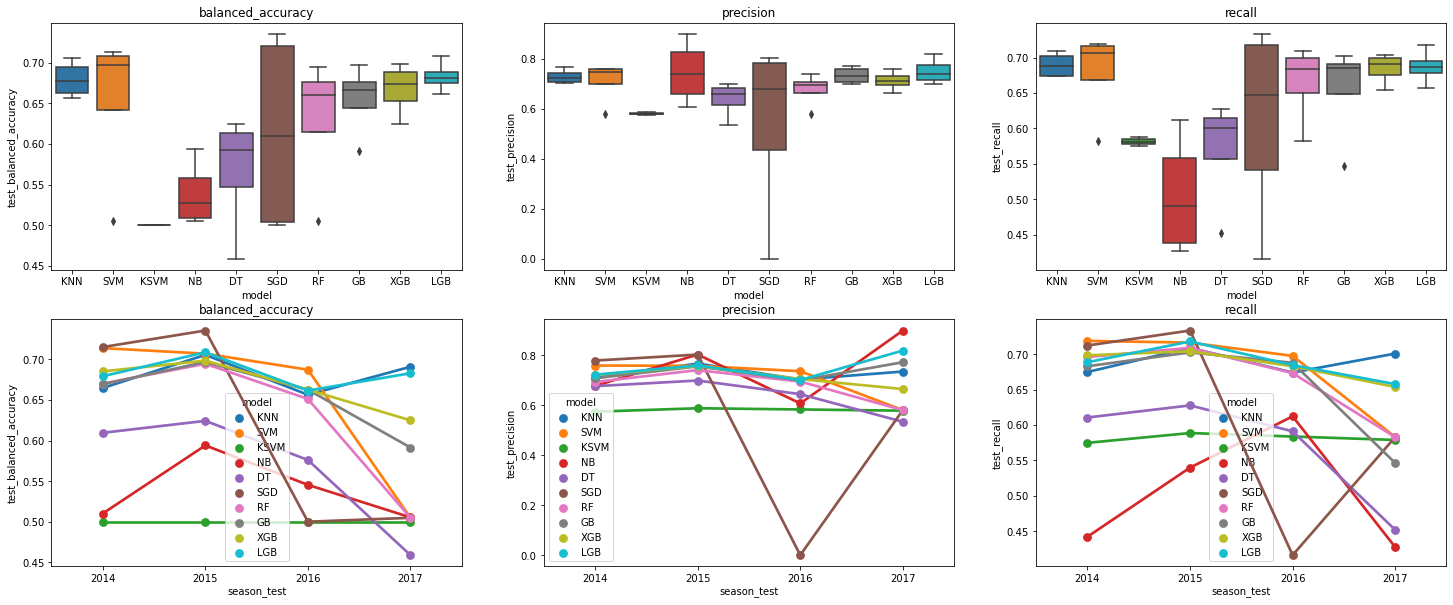

In [17]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

Se observa lo siguiente:

- KSVM: continua siempre prediciendo true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%(como para las demas metricas que tambien estan balanceadas).

- Se observa como los algoritmos mas estables fueron:

    - ***LGB***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.6829856103519845 - 0.01684209164438598. LGB siendo entrenado con un dataset escalado evidencia una peque~a mejoria en estos resultados comparados con los anteriores(0.6726459601145429 - 0.022280716932570364). ***La cual desde mi punto de vista no es significativa.***
    - ***KNN***: Obtuvo el segundo promedio mas alto. 0.6792983447415086 - 0.0197533788391945.
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.667716032533138 - 0.027865425583437218. Tambien se observa que presenta una desviacion estandar mucho mas alta que los algoritmos anteriores.
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment: train: 2s; test: 1s

In [18]:
experiment_name = f"{exp_prefix}2_seasons"

In [19]:
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 2_seasons
KNN
balanced_accuracy: 0.6481858982734702 - 0.015224307863230946
precision: 0.7008333113171824 - 0.018410733847702268
recall: 0.6634146341463415 - 0.01307570523773963
f1: 0.6609000463616854 - 0.014579075183748753
roc_auc: 0.6481858982734702 - 0.015224307863230946
SVM
balanced_accuracy: 0.7036452819063674 - 0.011312679852710191
precision: 0.7450268891430758 - 0.020039676717009326
recall: 0.7173441734417345 - 0.008663613746962518
f1: 0.7148139556490135 - 0.009049734454968695
roc_auc: 0.7036452819063674 - 0.011312679852710167
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.00398291015086696
recall: 0.583739837398374 - 0.00398291015086696
f1: 0.4303213373600851 - 0.004789922726465058
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5609709352077221 - 0.05601671826365044
precision: 0.6377850775481286 - 0.038258196207968234
recall: 0.562059620596206 - 0.09724957831612385
f1: 0.4946038829438117 - 0.14034981884167733
roc_auc: 0.5609709352077221 - 0.056

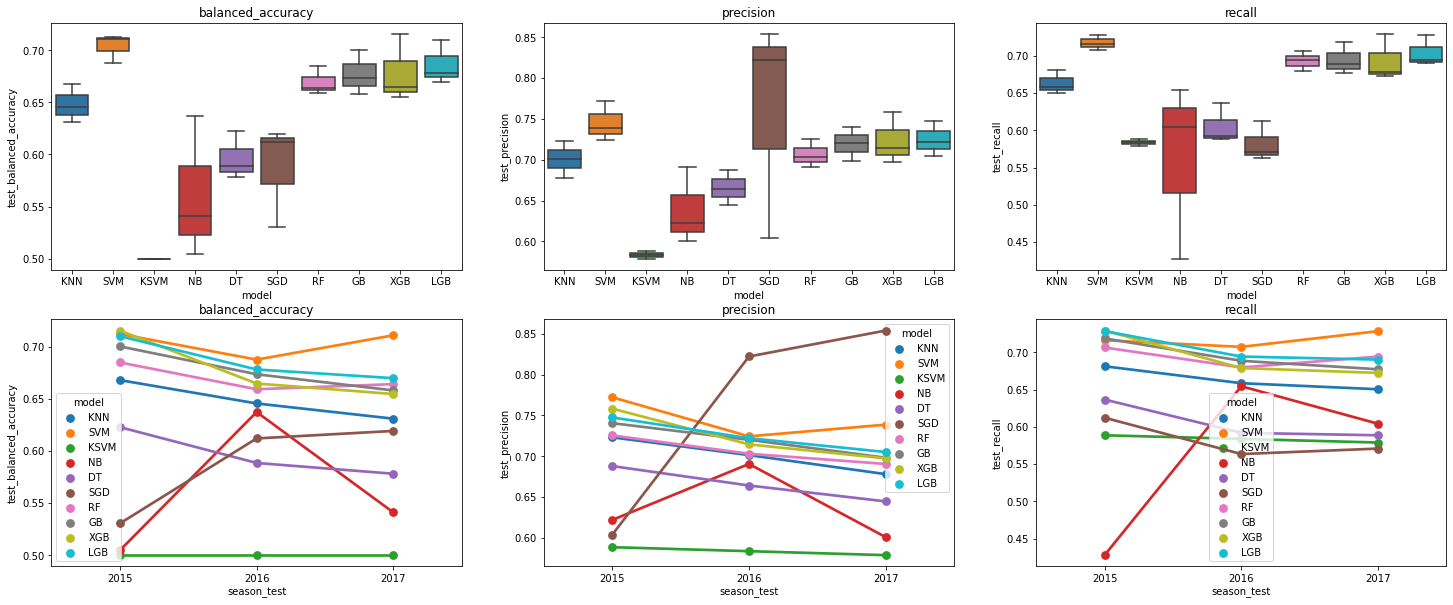

In [20]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.7036452819063674 - 0.011312679852710191, incluso aun mejor que los experimentos anteriores(balanced_accuracy: 0.6925515127344388 - 0.01854879007225907)
    - ***LGB***: Obtuvo el segundo promedio mas alto. 0.6860596053592324 - 0.017356982173576504
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.6783107202886427 - 0.026668639103027844
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment train: 3q ; test: 1q

In [21]:
experiment_name = f"{exp_prefix}3q_1q"

In [22]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3q_1q


ValueError: Found array with 0 sample(s) (shape=(0, 41)) while a minimum of 1 is required.

In [ ]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy pero a su vez fue el algoritmo con la desviacion estandar mas alta tambien. 0.7052866631416359 - 0.07373990913507918
    - ***LGB***: Obtuvo el segundo promedio mas alto. 0.6821197003531208 - 0.04791749773702776
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.6817549637812932 - 0.04870051822135649
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment train: 4q ; test: 2q

In [ ]:
experiment_name = f"{exp_prefix}4q_2q"

In [ ]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

In [ ]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy, inclusive de todos los experimentos este es el mas alto resultado. 0.7556939751261598 - 0.011406877715782774
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.7119226350413443 - 0.019108821398317707
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.7037161334648927 - 0.023074904030555104
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment remove first 1q ; train: 2q ; test: 1q

In [ ]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [ ]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

In [ ]:
#### Visualize experiments results
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy pero con una desviacion estandar mas alta que los siguientes algoritmos en el top del promedio mas alto. 0.6514141774238262 - 0.05234245335081721
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.632512284207538 - 0.04033560641373664
    - ***RF***: Obtuvo el tercer promedio mas alto. 0.6302538460680835 - 0.04531897469391061
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

## Experiments comparison

In [30]:
utils.serialize_object(exp_group_name, exp.exp_results)

In [38]:
exp_df = pd.DataFrame(exp.exp_results)

In [39]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [40]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [62]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,4q_2q,SVM,0.755694,0.011407
1,4q_2q,XGB,0.711923,0.019109
2,4q_2q,LGB,0.703716,0.023075
3,2_seasons,SVM,0.703645,0.011313
4,1_season,SVM,0.692552,0.018549
5,2_seasons,LGB,0.686060,0.017357


Se observa:

- El algoritmo SVM fue el que obtuvo el mejor rendimiento.
- Se obtuvo mejor rendimiento utilizando 
    
    

### Comparing with other results

### Comparing with other results

## Plot experiment results

In [34]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

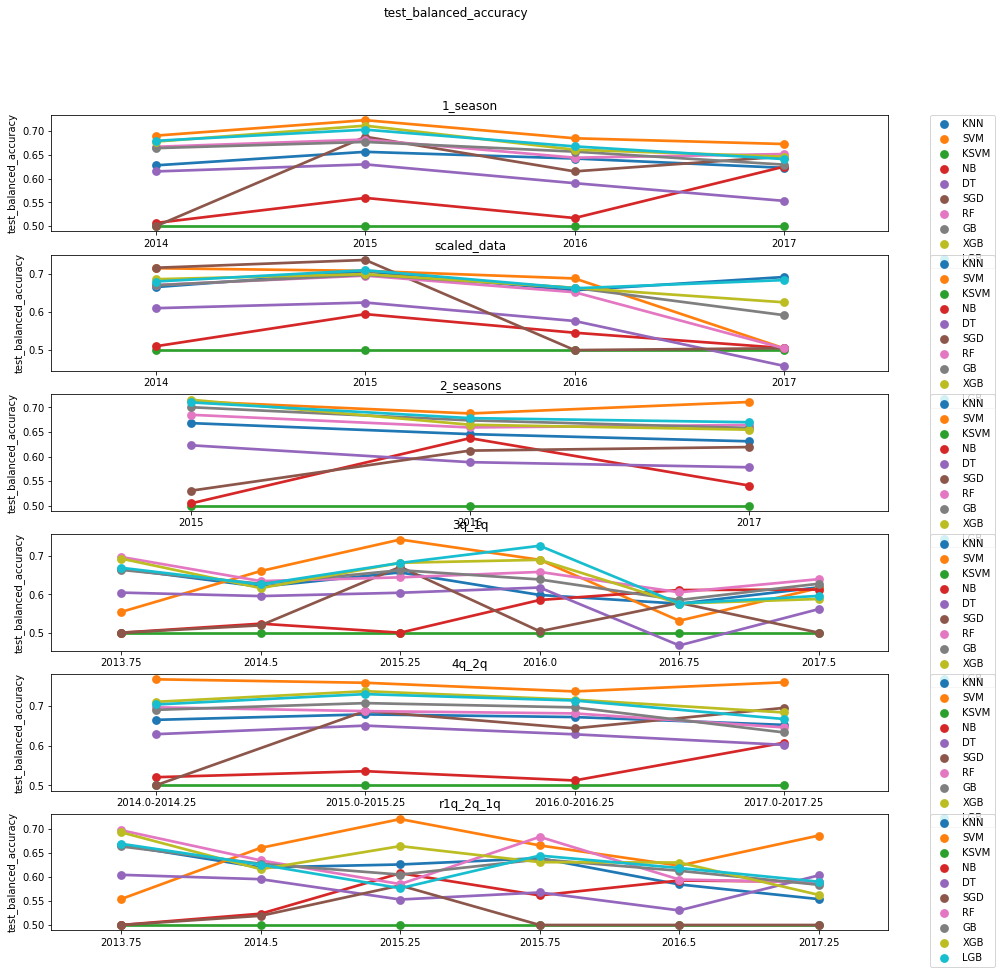

In [35]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

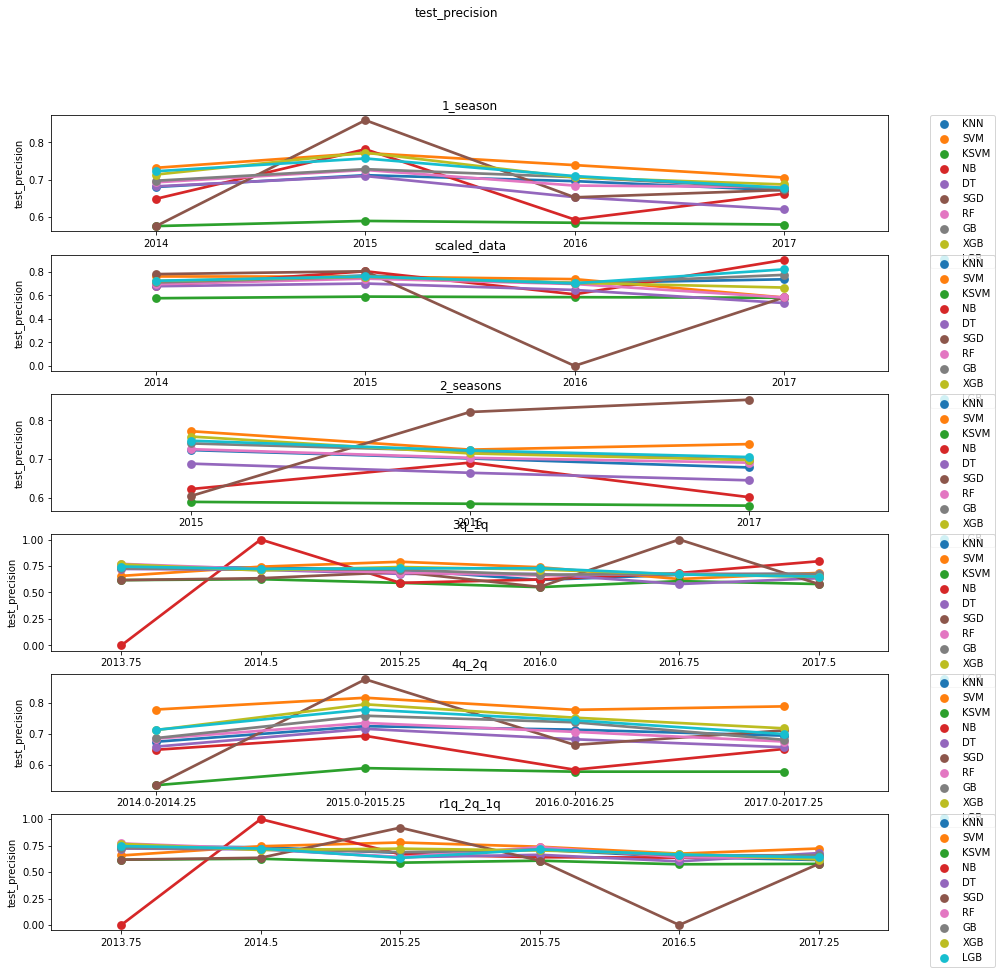

In [36]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

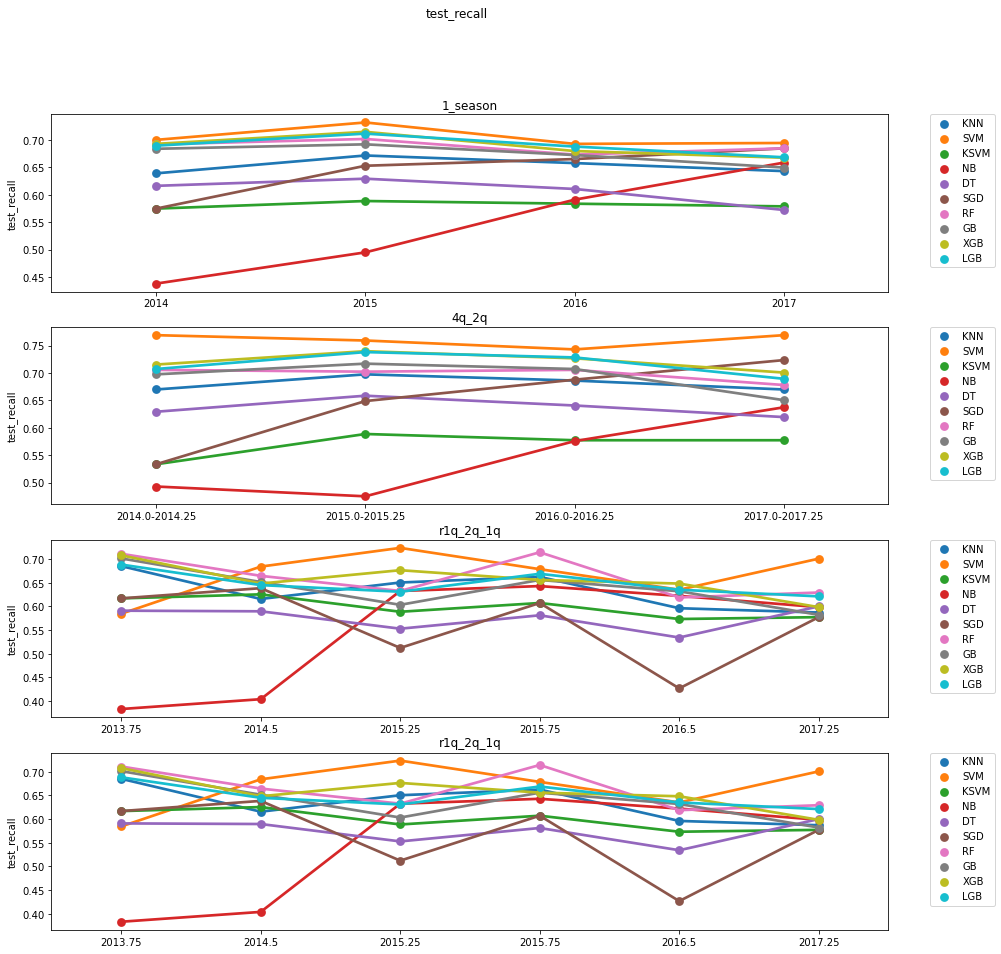

In [40]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

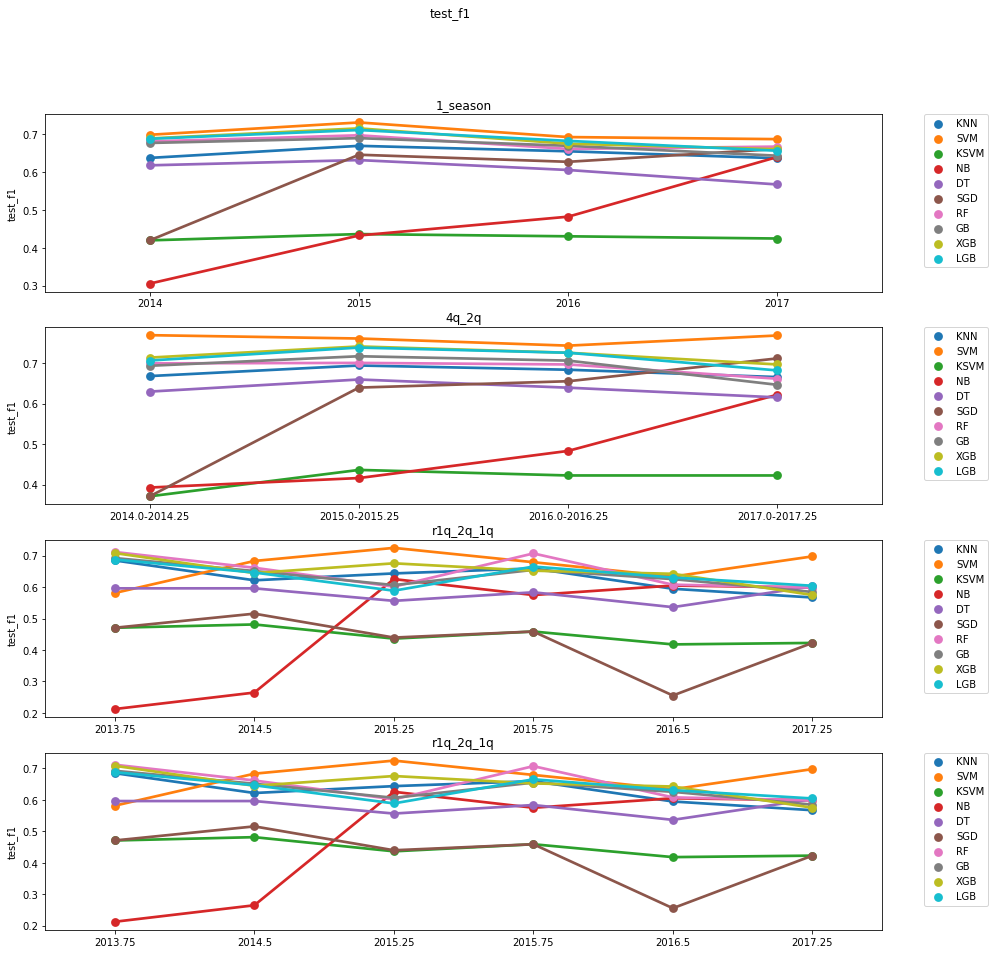

In [41]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

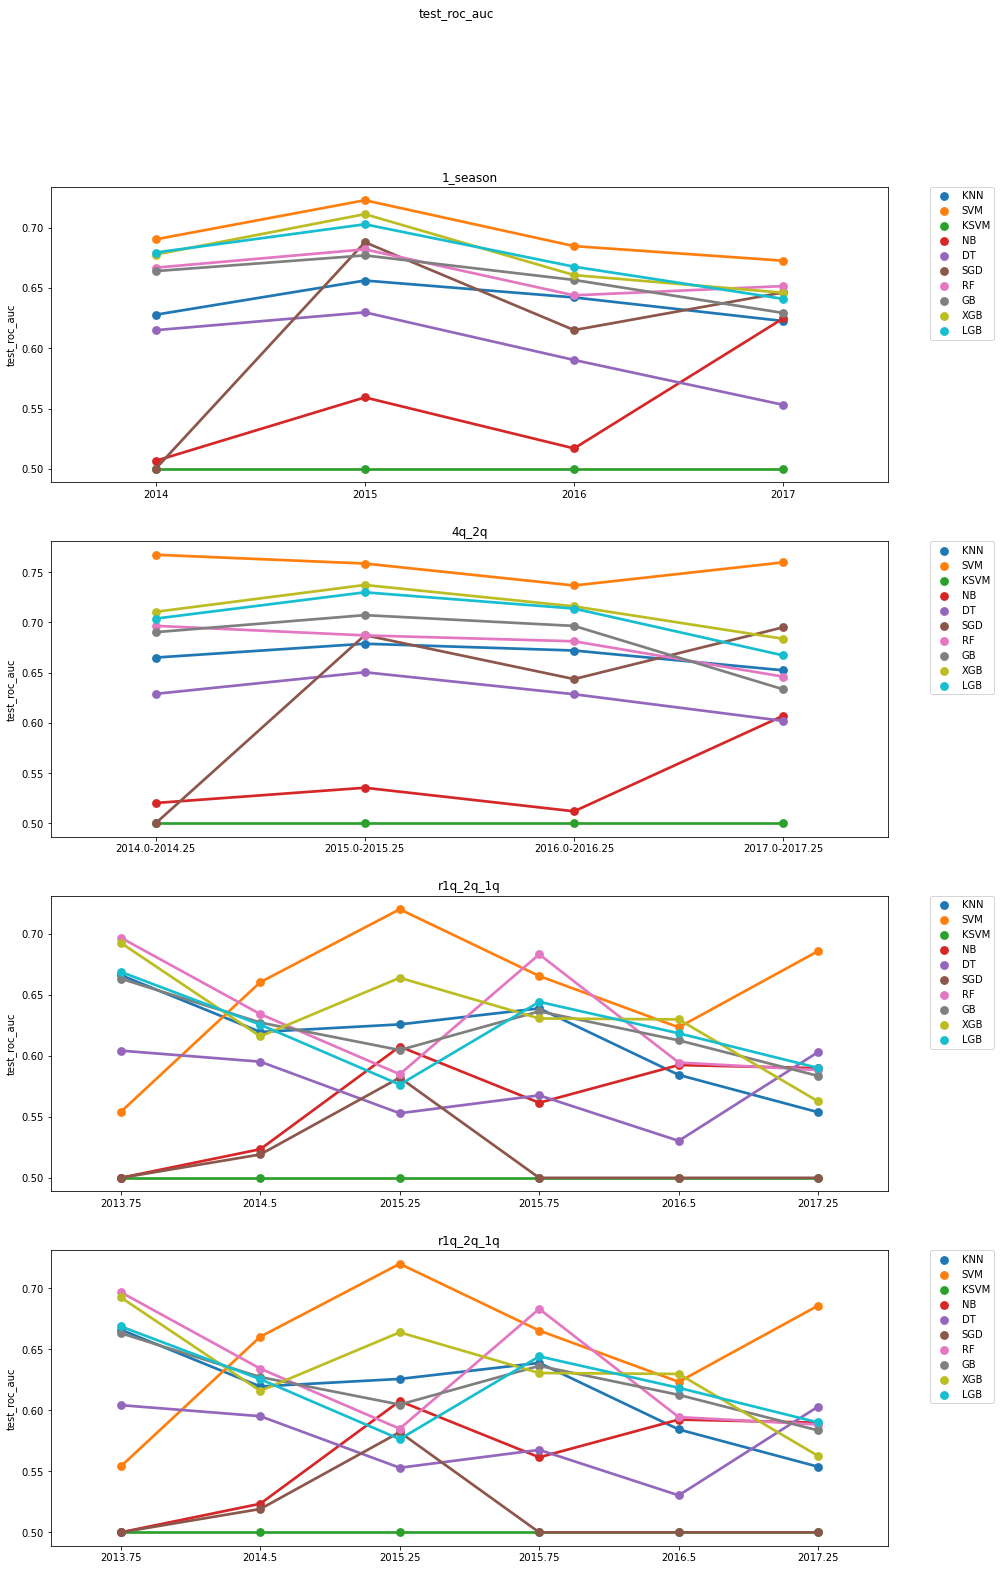

In [42]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Test a specific model

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])